<a href="https://colab.research.google.com/github/MedjialeuJordan/Machine-Learning-Projects/blob/main/Stenogram%20transcriprion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import re


file_path = '/content/train+valid.steno.txt'
with open(file_path,"r",encoding="utf-8") as f:
  lines = f.readlines()

#Construction des lignes et du vocabulaire
grapheme=[] #mots français
phoneme=[] #transcription phonétique

for line in lines:
  if "::" in line:
    g,p=line.strip().split("::")
    grapheme.append(list(g.strip()))
    phoneme.append(p.strip().split())
#Vocabulaire pour traitement des sequences
def build_vocab(sequences):
  #pad: padding, sos: start of sequence,eos: end of sequence
  vocab={"<pad>": 0, "<sos>":1, "<eos>":2, "<unk>":3}
  for seq in sequences:
    for token in seq:
      if token not in vocab:
        vocab[token]=len(vocab)
  return vocab
#creation des dictionnaires
grapheme_vocab = build_vocab(grapheme)
phoneme_vocab = build_vocab(phoneme)
#permets d'inverser le dictionaire phomène->index pour retrouver les phonèmes à partir de l'indice
inv_phenome_vocab = {v: k for k, v in phoneme_vocab.items()}


#transformer les sequences en indices
def seq_to_indices(seq,vocab,add_sos_eos=True):
  indices = [vocab.get(token,vocab["<unk>"]) for token in seq]
  if add_sos_eos:
    indices = [vocab["<sos>"]] + indices + [vocab["<eos>"]]
  return indices

X= [seq_to_indices(seq,grapheme_vocab) for seq in grapheme] #données d'entrée
Y= [seq_to_indices(seq,phoneme_vocab) for seq in phoneme] # étiquettes

#Creation of the Dataset and Dataloader
class G2PDataset(Dataset):
  def __init__(self,X,Y):
    self.X=X
    self.Y=Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    return torch.tensor(self.X[idx]),torch.tensor(self.Y[idx])

#Padding
def collate_fn(batch):
    x, y = zip(*batch) #cette ligne separe les entrées des cibles
    x = [torch.tensor(seq) if not isinstance(seq, torch.Tensor) else seq for seq in x]
    y = [torch.tensor(seq) if not isinstance(seq, torch.Tensor) else seq for seq in y]
    #convertir en tensors
    x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=grapheme_vocab["<pad>"])
    y_padded = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=phoneme_vocab["<pad>"])
    return x_padded, y_padded



x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2,random_state=42)#division en dataset
train_loader= DataLoader(G2PDataset(x_train,y_train),batch_size=32,shuffle=True,collate_fn=collate_fn)
val_loader= DataLoader(G2PDataset(x_val,y_val),batch_size=32,shuffle=False,collate_fn=collate_fn)




#Encoding,Decoding of the sequences and training of the model

Encodeur sert a transformé une sequences d'entrée(graphèmes) en un etat caché qui resume l'info contenue dans la sequence

Decodeur permets de generer les sequences de sorties

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 01 | Train Loss: 3.5263 | Val Loss: 2.6451
Epoch 02 | Train Loss: 2.0360 | Val Loss: 1.7489
Epoch 03 | Train Loss: 1.3832 | Val Loss: 1.3434
Epoch 04 | Train Loss: 1.0646 | Val Loss: 1.1593
Epoch 05 | Train Loss: 0.8842 | Val Loss: 0.9973
Epoch 06 | Train Loss: 0.7720 | Val Loss: 0.9137
Epoch 07 | Train Loss: 0.6953 | Val Loss: 0.8611
Epoch 08 | Train Loss: 0.6362 | Val Loss: 0.8154
Epoch 09 | Train Loss: 0.5937 | Val Loss: 0.7788
Epoch 10 | Train Loss: 0.5572 | Val Loss: 0.7606


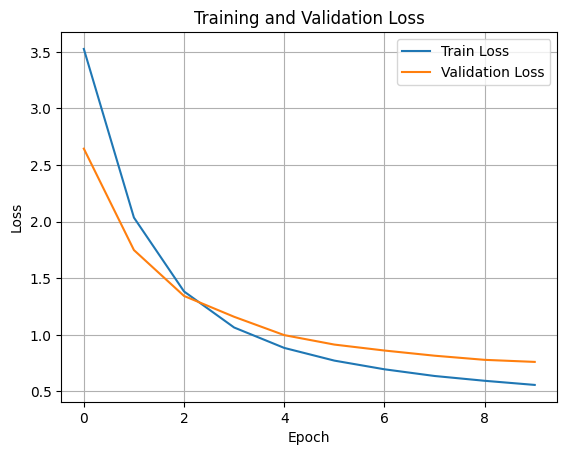

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self,input_size,hidden_size):
    super().__init__()
    self.embedding= nn.Embedding(input_size,hidden_size, padding_idx=grapheme_vocab["<pad>"])#convertir les indices en vecteurs continus
    self.rnn= nn.LSTM(hidden_size,hidden_size,batch_first=True,dropout=0.3)

  def forward(self,x):
    embedded=self.embedding(x)
    output,(hidden,cell)=self.rnn(embedded)
    return output,hidden,cell

class Decoder(nn.Module):
  def __init__(self,output_size,emb_size,hidden_size):
    super().__init__()
    self.embedding=nn.Embedding(output_size,emb_size,padding_idx=grapheme_vocab["<pad>"])
    self.rnn=nn.LSTM(emb_size,hidden_size,batch_first=True,dropout=0.3)
    self.fc=nn.Linear(hidden_size,output_size)

  def forward(self,input,hidden,cell):
    input=input.unsqueeze(1)
    embedded=self.embedding(input)
    output,(hidden,cell)=self.rnn(embedded,(hidden,cell))
    prediction=self.fc(output.squeeze(1))
    return prediction,hidden,cell

class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.device=device

  def forward(self,src,trg,teacher_forcing_ratio=0.5):
    batch_size=src.size(0)
    trg_len=trg.size(1)
    trg_vocab_size=self.decoder.embedding.num_embeddings

    outputs= torch.zeros(batch_size,trg_len,trg_vocab_size).to(self.device)
    _,hidden,cell=self.encoder(src)

    input = trg[:,0]
    #permets la generation des phomènes
    for t in range(1,trg_len):
      output,hidden,cell=self.decoder(input,hidden,cell)
      outputs[:,t]=output.squeeze(1)
      top1 = output.argmax(1)
      input = trg[:,t] if np.random.rand() < teacher_forcing_ratio else top1
    return outputs



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_Dim=64
hidden_Dim=64

enc=Encoder(len(grapheme_vocab),embedding_Dim)
dec=Decoder(len(phoneme_vocab),embedding_Dim,hidden_Dim)
model=Seq2Seq(enc,dec,device).to(device)

optimizer=optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss(ignore_index=grapheme_vocab["<pad>"])

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for x, y in iterator:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x, y)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        y = y[:, 1:].reshape(-1)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for x, y in iterator:
            x, y = x.to(device), y.to(device)
            output = model(x, y, 0)  # no teacher forcing
            output = output[:, 1:].reshape(-1, output.shape[-1])
            y = y[:, 1:].reshape(-1)
            loss = criterion(output, y)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Training loop with graph
train_losses = []
val_losses = []
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1:02} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), 'model.pth')

# Plot loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


#Entrainement sur les données de Test

In [ ]:
model.load_state_dict(torch.load('model.pth'))
model.eval()


test_path="/content/test.txt"
test_grapheme=[]

with open(test_path,"r",encoding="utf-8") as f:
  lines=f.readlines()
  for line in lines:
    if "::" in line:
      g,_=line.strip().split("::")
      test_grapheme.append(list(g.strip()))

X_test=[seq_to_indices(seq,grapheme_vocab,add_sos_eos=True) for seq in test_grapheme]

dummy_targets=[[phoneme_vocab["<pad>"]]] * len(X_test)
test_dataset=G2PDataset(X_test,dummy_targets)
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False,collate_fn=collate_fn)


def predict(model,dataloader):
  model.eval()
  predictions=[]
  with torch.no_grad():
    for x,_ in dataloader:
      x=x.to(device)
      _, hidden, cell=model.encoder(x)
      input_token=torch.tensor([phoneme_vocab["<sos>"]]).to(device)
      output_seq=[]
      for _ in range(100):
        output,hidden,cell=model.decoder(input_token,hidden,cell)
        top1=output.argmax(1)
        if top1.item()==phoneme_vocab["<eos>"]:
          break
        output_seq.append(top1.item())
        input_token=top1
      predictions.append(output_seq)
  return predictions

predictions=predict(model,test_loader)
decoded_predictions=["".join([inv_phenome_vocab[idx] for idx in seq]) for seq in predictions]

# Affichage des résultats
for g, p in zip(test_grapheme, decoded_predictions):
    print("".join(g), "→", p)

# Optionnel : sauvegarder dans un fichier CSV
import pandas as pd

df_out = pd.DataFrame({
    "Grapheme": ["".join(g) for g in test_grapheme],
    "Predicted Phoneme": decoded_predictions
})
df_out.to_csv("g2p_predictions.csv", index=False)



Streaming output truncated to the last 5000 lines.
amadouons → AMOT*OUO#
briderez → P*RIDRE
hybridations → IP*RIT*A(
Gutemberg → K*OUDP*EL
humilions → UMILYO#
amadouions → AMOT*OUYO#
regrimpés → RK*RI#PE
doutées → T*OUTE
scandalisez → SKA#T*ALIS*E
centralienne → SA#TRALI$
Cap-Vert → KAF*EL
carême → KARE#
déguster → T*EK*U$TE
décrédibiliserait → T*EKRET*IP*ILI$RE
relancerai → RA#$
céphalopode → PEFOFALO
cariatide → KATYE
brayait → P*REYE
désemprisonne → T*ES*A#PRIS*O#(
africain → AFRIKI#
affrontement → ADMA#DMA#
stratifieras → STRATFIRA
regonflions → RK*O#FLYO#
décéderons → T*ESEDRO#
mazouterai → SKAMATRE
jordanien → P*OLK*ONI
stérilisait → STERLIS*E
assoupliras → ASOUPLIRA
je me rends compte → YA#MRA#KO#D
Tribunal arbitral → TRIP*ALT*UPALRAL
exonderiez → E(S*O#DRYE
standing → STA#T*I(
herboriste → ELP*ORI$D
consulta → KO#SULTA
débarbouillent → T*EP*ALP*OUI
dématérialisant → T*EMATERYALIS*A#
réadmets → REAMA#
aéronaval → AEROPARO#D(MA#
corrective → KORE(TI$
trésoreries 

#Applications du modeles sur les phrases de Wikipedia

In [ ]:
!pip install wikipedia

In [ ]:
import wikipedia
import random

wikipedia.set_lang("fr")

def get_random_sentence(n=5000):
  sentences = []
  while len(sentences) < n:
    try:
      page=wikipedia.page(wikipedia.random())
      for sentence in page.content.split("."):
        sentence = sentence.strip()
        if 30 < len(sentence) < 200:
          sentences.append(sentence)
          if len(sentences)>=n:
            break
    except Exception as e:
      continue
  return sentences

phrases=get_random_sentence()




/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
import torch
import re

def convertisseur_phrase(phrase, model, device, grapheme_vocab, phoneme_vocab, inv_phenome_vocab, max_len=30):
    words = phrase.strip().split()
    steno_words = []

    for word in words:
        word_clean = re.sub(r"[^a-zA-ZÀ-ÿ\-]", "", word)
        if not word_clean:
            continue

        indices = [grapheme_vocab.get(c.lower(), grapheme_vocab["<unk>"]) for c in word_clean]
        indices = [grapheme_vocab["<sos>"]] + indices + [grapheme_vocab["<eos>"]]
        x_tensor = torch.tensor(indices).unsqueeze(0).to(device)

        with torch.no_grad():
            _, hidden, cell = model.encoder(x_tensor)
            input_token = torch.tensor([phoneme_vocab["<sos>"]]).to(device)

            output_seq = []
            for _ in range(max_len):
                output, hidden, cell = model.decoder(input_token, hidden, cell)
                top1 = output.argmax(1).item()

                if top1 == phoneme_vocab["<eos>"]:
                    break
                if len(output_seq) >= 3 and output_seq[-1] == output_seq[-2] == top1:
                    break
                output_seq.append(top1)
                input_token = torch.tensor([top1]).to(device)

        decoded = "".join([inv_phenome_vocab.get(idx, "?") for idx in output_seq])
        steno_words.append(decoded)

    return " ".join(steno_words)


# Générer les 5000 paires sténo <-> texte
import pandas as pd

# Générer les paires sténo <-> français
corpus_steno = []
for phrase in phrases:  # phrases = liste des phrases Wikipedia
    steno = convertisseur_phrase(
        phrase,
        model,
        device,
        grapheme_vocab,
        phoneme_vocab,
        inv_phenome_vocab
    )

    # Filtrage qualité
    if (
        steno.strip()
        and "<unk>" not in steno
        and len(steno.strip()) >= 5
        and not any(c.isdigit() for c in phrase)
        and len(phrase.split()) >= 4
        and len(phrase.split()) <= 30
    ):
        corpus_steno.append([steno, phrase])

# Création du DataFrame
df = pd.DataFrame(corpus_steno, columns=["Phrase steno", "Phrase en français"])

# Sauvegarde en CSV
df.to_csv("corpus_steno.csv", index=False, encoding="utf-8")

print(f"✅ Corpus CSV généré avec {len(df)} paires dans 'corpus_steno.csv'")


✅ Corpus CSV généré avec 2682 paires dans 'corpus_steno.csv'


In [ ]:
print(convertisseur_phrase("championnat saison france ligue édition", model, device, grapheme_vocab, phoneme_vocab, inv_phenome_vocab, max_len=30))


In [ ]:
!pip install transformers datasets

In [ ]:
def post_process_steno(text):
    return re.sub(r"[^a-zA-ZÀ-ÿ\-]", "", text)

In [ ]:
import pandas as pd
import re

# Charger le fichier CSV brut
df = pd.read_csv("corpus_steno.csv", encoding="utf-8")

# Renommer les colonnes si nécessaire
if df.columns[0].lower().startswith("phrase") and not "Phrase steno" in df.columns:
    df.columns = ["Phrase steno", "Phrase en français"]

# Fonction de filtrage des lignes douteuses
def is_valid_row(row):
    steno = row["Phrase steno"]
    phrase = row["Phrase en français"]

    # Éliminer les tokens spéciaux et wiki
    if any(bad in phrase for bad in ["==", "[", "]", "»", "«", "Portail", "Catégorie", "retrouvez", "voir aussi"]):
        return False
    if "<unk>" in steno:
        return False
    if len(steno.strip()) < 5:
        return False
    if any(char.isdigit() for char in phrase):
        return False
    word_count = len(phrase.strip().split())
    if word_count < 4 or word_count > 30:
        return False
    return True

# Appliquer le filtre
df_clean = df[df.apply(is_valid_row, axis=1)]

# Nettoyage final de la colonne sténo (suppression de caractères spéciaux inutiles)
def post_process_steno(text):
    return re.sub(r"[^a-zA-ZÀ-ÿ\- ]", "", text)

df_clean["Phrase steno"] = df_clean["Phrase steno"].apply(post_process_steno)

# Sauvegarder le corpus nettoyé
df_clean.to_csv("clean_wikipedia_steno.csv", index=False, encoding="utf-8")
print(f"✅ Corpus nettoyé : {len(df_clean)} lignes conservées dans 'clean_wikipedia_steno.csv'")



✅ Corpus nettoyé : 2160 lignes conservées dans 'clean_wikipedia_steno.csv'


<ipython-input-42-cb3a560f5614>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Phrase steno"] = df_clean["Phrase steno"].apply(post_process_steno)


#Pretraitement des données

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import T5Tokenizer,T5ForConditionalGeneration

# 1. Charger le corpus nettoyé
df = pd.read_csv("clean_wikipedia_steno.csv", encoding="utf-8")

# 2. Ajouter un préfixe pour T5 (utile pour multi-tâches)
df["input_text"] = "transcrire : " + df["Phrase steno"]
df["target_text"] = df["Phrase en français"]

dataset = Dataset.from_pandas(df[["input_text", "target_text"]])

# 4. Séparer en train/validation (80/20)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

tokenizer = T5Tokenizer.from_pretrained("t5-small")  # ou "./fine-tuned-t5" si déjà fine-tuné
model = T5ForConditionalGeneration.from_pretrained("t5-small")

for i in range(5):
    print(f"📝 Exemple {i+1}")
    print("Input text   :", train_dataset[i]["input_text"])
    print("Target text  :", train_dataset[i]["target_text"])
    print("---")
# Définir le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MAX_LEN = 128

def preprocess(example):
    input = tokenizer(example["input_text"], padding="max_length", truncation=True, max_length=MAX_LEN)
    labels = tokenizer(example["target_text"], padding="max_length", truncation=True, max_length=MAX_LEN)
    input["labels"] = labels["input_ids"]
    return input
train_dataset = train_dataset.map(preprocess, batched=True)
val_dataset = val_dataset.map(preprocess, batched=True)

tokenized_dataset = dataset.map(preprocess, batched=True)

print(" Données prétraitées prêtes à l'entraînement ou à l'évaluation.")


📝 Exemple 1
Input text   : transcrire : RAPLA SKALNAD A ORE OTNU MEYEUL ATEUL
Target text  : Raphaël Quenard, Q d'or du meilleur acteur
---
📝 Exemple 2
Input text   : transcrire : AI PFID AAL UTILISE LE MATRI O KIT NITONAD LAPO ASYO AAL LE PROPR MATRI
Target text  : Ils peuvent alors utiliser les matériaux des kits Nintendo Labo ou alors leurs propres matériaux
---
📝 Exemple 3
Input text   : transcrire : A KOTRIYEUL FINASYE ATR LALYID OPA AI KRKL O AAL TIRESYO OTNU FSTALI
Target text  : Un contrôleur financier entre également dans le cercle de la direction du Festival
---
📝 Exemple 4
Input text   : transcrire : SET AAL PRMYEL FOI A AI KLOSUD RAPOLD SED TITR
Target text  : C'est la première fois que le club remporte ce titre
---
📝 Exemple 5
Input text   : transcrire : KLIDEA AAL TI LE OSID KOPE FO O AFA O SEUL YUMEL ME SOLAY A TEILI LE IKNOL FRETRA OMOUL KLIDEA O RLA SA MATE
Target text  : À la fin, les deux danseurs font des avances aux sœurs jumelles, mais Solange et Delphine les igno

Map:   0%|          | 0/1728 [00:00<?, ? examples/s]

Map:   0%|          | 0/432 [00:00<?, ? examples/s]

Map:   0%|          | 0/1728 [00:00<?, ? examples/s]

Map:   0%|          | 0/432 [00:00<?, ? examples/s]

✅ Données prétraitées prêtes à l'entraînement ou à l'évaluation.


📦 Device utilisé : cuda


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=200,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)
trainer.train()

trainer.save_model("./fine-tuned-t5")
tokenizer.save_pretrained("./fine-tuned-t5")


<ipython-input-44-bca0d30d51b4>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
200,1.757500
400,0.943800
600,0.895800
800,0.873800
1000,0.868800
1200,0.853800
1400,0.855500
1600,0.832000
1800,0.838000
2000,0.823500


('./fine-tuned-t5/tokenizer_config.json',
 './fine-tuned-t5/special_tokens_map.json',
 './fine-tuned-t5/spiece.model',
 './fine-tuned-t5/added_tokens.json')

In [ ]:
from jiwer import wer
from tqdm import tqdm
import re

# Nettoyage des caractères parasites
def post_process_steno(text):
    return re.sub(r"[^a-zA-ZÀ-ÿ\-]", "", text)

# Normalisation : minuscule + suppression d'espaces inutiles
def normalize_text(text):
    return re.sub(r"\s+", " ", text.strip().lower())

# Évaluation complète sur un dataset
def evaluate_t5(model, dataset, tokenizer, max_len=128):
    model.eval()
    predictions = []
    references = []

    for item in tqdm(dataset, desc="Évaluation du modèle"):
        input_ids = tokenizer.encode(item["input_text"], return_tensors="pt", truncation=True, max_length=max_len).to(model.device)
        with torch.no_grad():
            output_ids = model.generate(input_ids, max_length=max_len)
        pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        ref = item["target_text"]

        # Nettoyage
        predictions.append(post_process_steno(normalize_text(pred)))
        references.append(post_process_steno(normalize_text(ref)))

    # Calcul du WER
    error_rate = wer(references, predictions)
    print(f"\n✅ Word Error Rate (WER) final : {error_rate:.4f}")

    return predictions, references, error_rate


In [ ]:
# Évaluation
preds, refs, wer_score = evaluate_t5(model, val_dataset, tokenizer)


Évaluation du modèle: 100%|██████████| 432/432 [04:19<00:00,  1.66it/s]


✅ Word Error Rate (WER) final : 1.0000


In [ ]:
def show_predictions_30(model, dataset, tokenizer, n=30, max_len=128):
    model.eval()
    data = []

    for item in dataset.select(range(n)):
        input_text = item["input_text"]                      # ex : "transcrire : LA TAPRE..."
        steno_input = input_text.replace("transcrire : ", "")  # enlever le préfixe
        target_text = item["target_text"]                    # phrase attendue

        # Génération
        input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=max_len).to(model.device)
        with torch.no_grad():
            output_ids = model.generate(input_ids, max_length=max_len)
        pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        data.append([steno_input, pred_text, target_text])

    # Affichage dans un tableau
    import pandas as pd
    df = pd.DataFrame(data, columns=["Entrée sténogramme", "Phrase prédite", "Phrase attendue"])
    display(df)
    return df

